# Step 3 - Points of interest based bicycle network generation
## Project: Growing Urban Bicycle Networks

This notebook follows the transit-oriented development approach of palominos2020ica or a grid approach and applies cardillo2006spp: Take the greedy triangulation between railway/underground stations (or other points of interest created in 02_prepare_pois). This is the cold start bicycle network generation process which creates bicycle networks from scratch.

Contact: Michael Szell (michael.szell@gmail.com)  
Created: 2020-06-18  
Last modified: 2021-01-23

## Preliminaries

### Parameters

In [55]:
debug = True # If True, will produce plots and/or verbose output to double-check
%run -i "../parameters/parameters.py"

Loaded parameters.



### Setup

In [56]:
%run -i path.py
%run -i setup.py

%load_ext watermark
%watermark -n -v -m -g -iv

Loaded PATH.



=== Cities ===
{   'newcastle': {   'countryid': 'gbr',
                     'name': 'Newcastle upon Tyne',
                     'nominatimstring': 'Newcastle upon Tyne'}}


Setup finished.

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.12.6
IPython version      : 8.29.0

Compiler    : MSC v.1941 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
CPU cores   : 8
Architecture: 64bit

Git hash: fbf87fde8079a284b6ea364b1968131fdd06ab5f

osmnx     : 1.9.4
IPython   : 8.29.0
pyproj    : 3.7.0
networkx  : 3.3
haversine : 2.8.1
igraph    : 0.11.6
sys       : 3.12.6 | packaged by conda-forge | (main, Sep 22 2024, 14:01:26) [MSC v.1941 64 bit (AMD64)]
geopandas : 0.14.4
json      : 2.0.9
numpy     : 1.26.4
pandas    : 2.2.3
matplotlib: 3.8.4
fiona     : 1.10.1
geojson   : 3.1.0
tqdm      : 4.66.5


### Functions

In [57]:
%run -i functions.py

Loaded functions.



## Routing (shortest paths)

The function and code below currently routes between the edges of neighbourhoods, rather than from a single point to a single point. We then join the neighbourhoods up first, before considering the wider area. This wider area is derived from hexagonal tesslleations within the city boundaries.

In [58]:
# get nodes 

locations = {}
parameterinfo = osmnxparameters['carall']
G_caralls = {}
G_caralls_simplified = {}

for placeid, placeinfo in tqdm(cities.items(), desc="Cities"):
    print(f"Processing {placeid}")
    
    # Load Tesselation POIs (hard coded for now)
    with open(PATH["data"] + placeid + "/" + placeid + '_poi_' + 'tessellation' + '_nnidsbikeall.csv') as f:
        tessellation_nnids = [int(line.rstrip()) for line in f]


    # Load LTN POIs
    if placeinfo["nominatimstring"] != '':
        location = ox.geocoder.geocode_to_gdf(placeinfo["nominatimstring"])
        if location.geometry[0].geom_type == 'MultiPolygon':
            location = location.explode(index_parts=False).reset_index(drop=True)
        location = fill_holes(extract_relevant_polygon(placeid, shapely.geometry.shape(location['geometry'][0])))
    else:
        # https://gis.stackexchange.com/questions/113799/how-to-read-a-shapefile-in-python
        shp = fiona.open(PATH["data"] + placeid + "/" + placeid + ".shp")
        first = next(iter(shp))
        try:
            location = Polygon(shapely.geometry.shape(first['geometry']))  # If shape file is given as linestring
        except:
            location = shapely.geometry.shape(first['geometry'])
    locations[placeid] = location
    
    G_caralls[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'carall')
    G_caralls[placeid].graph["crs"] = 'epsg:4326'  # Needed for OSMNX's graph_to_gdfs in utils_graph.py
    G_caralls_simplified[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'carall_simplified')
    G_caralls_simplified[placeid].graph["crs"] = 'epsg:4326'  # Needed for OSMNX's graph_to_gdfs in utils_graph.py

    print(f"{placeid}: Loading and moving POIs")
    # Get the carall graph and location geometry
    location = locations[placeid]
    G_carall = G_caralls_simplified[placeid]

    # Load neighbourhoods and create GeoDataFrame for centroids
    neighbourhoods = load_neighbourhoods(PATH["data"] + placeid + "/")
    all_centroids = gpd.GeoDataFrame(columns=['neighbourhood_id', 'geometry'], crs='EPSG:4326')  
    

    # load tesselation points 
    tess_nodes = gpd.read_file(PATH["data"] + placeid + "/" + placeid + '_poi_tessellation.gpkg')

    exit_points = get_exit_nodes(neighbourhoods, G_carall)  # Requires osmnx G_carall, not igraph G_carall
        
    unique_id = 0  # Counter for unique IDs across neighbourhoods

    for name, gdf in neighbourhoods.items():  # Process each neighbourhood GeoDataFrame to get centroids, exit points, and neighbourhood IDs
        if gdf.empty:
            print(f"Warning: The GeoDataFrame for {name} is empty. Skipping...")
            continue
        print(f"Processing neighbourhoods in: {name}")

        # Assign a unique ID to each neighbourhood in the GeoDataFrame to reference throughout
        gdf['neighbourhood_id'] = range(unique_id, unique_id + len(gdf))
        if debug:
            print(f"Assigned neighbourhood_ids from {unique_id} to {unique_id + len(gdf) - 1} for {name}")

        # Get centroids to inherit 'neighbourhood_id'
        centroids_gdf = get_neighbourhood_centroids(gdf)
        all_centroids = pd.concat([all_centroids, centroids_gdf], ignore_index=True)
        unique_id += len(gdf)  # Increment by the number of neighbourhoods processed

    # Snap centroids to the closest nodes in the street network
    neighbourhood_nnids = set()
    for g in all_centroids['geometry']:
        n = ox.distance.nearest_nodes(G_carall, g.x, g.y)
        if n not in neighbourhood_nnids and haversine((g.y, g.x), (G_carall.nodes[n]["y"], G_carall.nodes[n]["x"]), unit="m") <= snapthreshold:
            neighbourhood_nnids.add(n)
    # Add nearest_node column to all_centroids by finding the nearest node for each centroid geometry
    all_centroids['nearest_node'] = all_centroids['geometry'].apply(
        lambda g: ox.distance.nearest_nodes(G_carall, g.x, g.y))  # We now have all_centroids with 'neighbourhood_id', 'geometry', 'nearest_node' columns
    
    ltn_nodes = all_centroids

Cities:   0%|          | 0/1 [00:00<?, ?it/s]

Processing newcastle
newcastle: Loading and moving POIs
1 Cities loaded


C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\networkGrowth\bikenwgrowth\code\functions.py:2000: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  exploded_gdf = gdf.explode().reset_index(drop=True)
c:\Users\b8008458\AppData\Local\miniforge3\envs\growbikenet\Lib\site-packages\IPython\core\interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\networkGrowth\bikenwgrowth\code\functions.py:1803: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration

Processing neighbourhoods in: Newcastle Upon Tyne
Assigned neighbourhood_ids from 0 to 9 for Newcastle Upon Tyne


In [60]:
# def delauny_triangulation(ltn_nodes, tessellation_nodes):
#     # give gdf points unqiue ids
#     ltn_nodes['id'] = range(1, len(ltn_nodes) + 1)
#     ltn_nodes['source'] = 'ltn'
#     tessellation_nodes['id'] = range(len(ltn_nodes) + 1, len(ltn_nodes) + 1 + len(tessellation_nodes))
#     tessellation_nodes['source'] = 'tess'

#     coords = [(point.x, point.y) for point in ltn_nodes.geometry]
#     tri = Delaunay(coords)
#     G = nx.Graph()

#     # Add nodes to the graph
#     for i, coord in enumerate(coords):
#         G.add_node(i, pos=coord)

#     # Add edges to the graph based on the triangulation
#     for simplex in tri.simplices:
#         for i in range(3):
#             for j in range(i + 1, 3):
#                 G.add_edge(simplex[i], simplex[j])
#     if debug:
#         pos = nx.get_node_attributes(G, 'pos')
#         nx.draw(G, pos, with_labels=True)
#         plt.show()

#     # find the neighbouring nodes for each ltn node
#     neighbours = {node: list(G.neighbors(node)) for node in G.nodes}
#     ltn_nodes['neighbours'] = ltn_nodes.index.map(lambda x: [ltn_nodes.loc[n]['id'] for n in neighbours.get(x, [])])

    



#     return ltn_nodes, tessellation_nodes



    

In [61]:
## get neighbouring ltn for each ltn 


# # Define a set of 5 test points
# test_points = [
#     Point(-1.7, 55.0),
#     Point(-1.65, 55.03),
#     Point(-1.6, 55.02),
#     Point(-1.62, 54.98),
#     Point(-1.68, 54.97)
# ]

# # Create a GeoDataFrame
# ltn_nodes = gpd.GeoDataFrame(geometry=test_points, crs="EPSG:4326")  # Set CRS as WGS84 for this example

if debug:
    ltn_nodes.head(10), tess_nodes.head(10)

def greedy_triangulation_ltns(ltn_points_gdf):

     # give gdf points unqiue ids
    ltn_points_gdf['id'] = range(1, len(ltn_points_gdf) + 1)
    ltn_points_gdf['source'] = 'ltn'


    # Extract coordinates of points
    points = list(ltn_points_gdf.geometry)
    coords = np.array([(point.x, point.y) for point in points])
    
    # Compute all possible edges with their distances
    edges = []
    for i, j in itertools.combinations(range(len(coords)), 2):
        distance = np.linalg.norm(coords[i] - coords[j])
        edges.append((i, j, distance))
    
    # Sort edges by distance
    edges = sorted(edges, key=lambda x: x[2])  # Sort by the distance (x[2])
    
    # Initialize triangulation
    selected_edges = []
    existing_lines = GeometryCollection()  # Use an empty GeometryCollection
    
    # Iterate over edges
    for i, j, distance in edges:
        new_edge = LineString([coords[i], coords[j]])
        
        # Check if this edge intersects existing edges
        if not existing_lines.crosses(new_edge):
            selected_edges.append((i, j, distance))
            # Update existing lines by adding the new edge
            existing_lines = unary_union([existing_lines, new_edge])

    # Create a GeoDataFrame for triangulated edges with additional attributes
    lines = []
    start_points = []
    end_points = []
    distances = []
    
    for i, j, distance in selected_edges:
        lines.append(LineString([coords[i], coords[j]]))
        start_points.append(i)  # Store the index of the starting point
        end_points.append(j)    # Store the index of the ending point
        distances.append(distance)  # Store the distance for this edge
    
    # Create GeoDataFrame with attributes
    greedy_triangulation_gdf = gpd.GeoDataFrame({
        'geometry': lines,
        'start_point': start_points,
        'end_point': end_points,
        'distance': distances
    }, crs=ltn_points_gdf.crs)

    
    return greedy_triangulation_gdf

# produce a 
greedy_triangulation_ltns_gdf = greedy_triangulation_ltns(ltn_nodes)

# get list of neighbouring node from the triangulation
G = nx.Graph()
# Iterate over the rows of the GeoDataFrame
for _, row in greedy_triangulation_ltns_gdf.iterrows():
    start = row['start_point']
    end = row['end_point']
    distance = row['distance']
    # Add the edge with attributes
    G.add_edge(start, end, geometry=row['geometry'], distance=distance)
ltn_node_pairs = []
for node in G.nodes:
    # Get the neighbours of the current node
    neighbours = list(G.neighbors(node))
    for neighbour in neighbours:
        # Ensure each pair is only added once
        if (neighbour, node) not in ltn_node_pairs:  # Avoid duplicates
            ltn_node_pairs.append((node, neighbour))
if debug:
    print(ltn_node_pairs)


   snap_status                   geometry  id source
66   unsnapped  POINT (-1.62952 55.00789)  77   tess
67     snapped  POINT (-1.64965 54.98402)  78   tess
68   unsnapped  POINT (-1.75530 55.00029)  79   tess
69   unsnapped  POINT (-1.76454 54.99514)  80   tess
70   unsnapped  POINT (-1.75038 54.99292)  81   tess
71   unsnapped  POINT (-1.77320 54.99623)  82   tess
72   unsnapped  POINT (-1.76835 55.00262)  83   tess
73   unsnapped  POINT (-1.67184 55.05528)  84   tess
74   unsnapped  POINT (-1.67907 55.05031)  85   tess
75   unsnapped  POINT (-1.62956 55.04134)  86   tess
Shortest path between (2, 4): [2, 4]
Shortest path between (2, 1): [2, 33, 1]
Shortest path between (2, 3): [2, 77, 3]
Shortest path between (2, 5): [2, 64, 16, 68, 5]
Shortest path between (2, 0): [2, 64, 46, 0]
Shortest path between (4, 3): [4, 3]
Shortest path between (4, 6): [4, 62, 6]
Shortest path between (4, 8): [4, 75, 8]
Shortest path between (4, 5): [4, 26, 47, 19, 5]
Shortest path between (7, 8): [7, 30

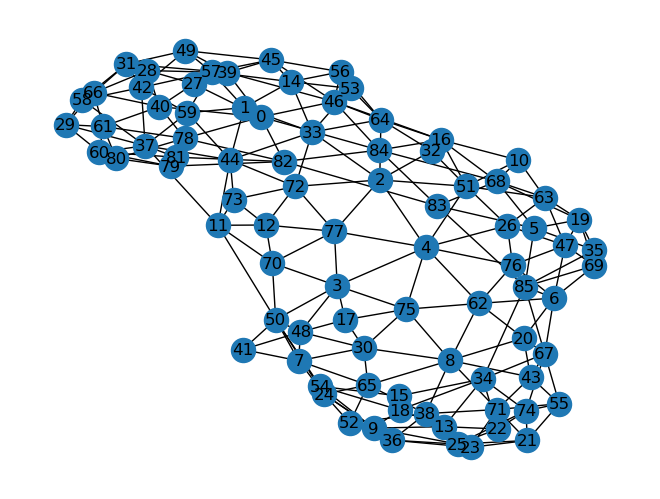

In [67]:
# create combined ltn and tessellation GT graph

def greedy_triangulation_all(ltn_points_gdf, tess_points_gdf):
    

     # give gdf points unqiue ids
    ltn_points_gdf['id'] = range(1, len(ltn_points_gdf) + 1)
    ltn_points_gdf['source'] = 'ltn'
    tess_points_gdf['id'] = range(len(ltn_points_gdf) + 1, len(ltn_points_gdf) + 1 + len(tess_points_gdf))
    tess_points_gdf['source'] = 'tess'

    print(tess_points_gdf.tail(10))

    all_points_gdf = gpd.GeoDataFrame(pd.concat([ltn_points_gdf, tess_points_gdf], ignore_index=True), crs=ltn_points_gdf.crs)

    # Extract coordinates of points
    points = list(all_points_gdf.geometry)
    coords = np.array([(point.x, point.y) for point in points])
    
    # Compute all possible edges with their distances
    edges = []
    for i, j in itertools.combinations(range(len(coords)), 2):
        distance = np.linalg.norm(coords[i] - coords[j])
        edges.append((i, j, distance))
    
    # Sort edges by distance
    edges = sorted(edges, key=lambda x: x[2])  # Sort by the distance (x[2])
    
    # Initialize triangulation
    selected_edges = []
    existing_lines = GeometryCollection()  # Use an empty GeometryCollection
    
    # Iterate over edges
    for i, j, distance in edges:
        new_edge = LineString([coords[i], coords[j]])
        
        # Check if this edge intersects existing edges
        if not existing_lines.crosses(new_edge):
            selected_edges.append((i, j, distance))
            # Update existing lines by adding the new edge
            existing_lines = unary_union([existing_lines, new_edge])

    # Create a GeoDataFrame for triangulated edges with additional attributes
    lines = []
    start_points = []
    end_points = []
    distances = []
    
    for i, j, distance in selected_edges:
        lines.append(LineString([coords[i], coords[j]]))
        start_points.append(i)  # Store the index of the starting point
        end_points.append(j)    # Store the index of the ending point
        distances.append(distance)  # Store the distance for this edge
    
    # Create GeoDataFrame with attributes
    greedy_triangulation_gdf = gpd.GeoDataFrame({
        'geometry': lines,
        'start_point': start_points,
        'end_point': end_points,
        'distance': distances
    }, crs=ltn_points_gdf.crs)

    
    return greedy_triangulation_gdf

greedy_triangulation_all_gdf = greedy_triangulation_all(ltn_nodes, tess_nodes)

# get list of neighbouring node from the triangulation
G = nx.Graph()
# Iterate over the rows of the GeoDataFrame
for _, row in greedy_triangulation_all_gdf.iterrows():
    start = row['start_point']
    end = row['end_point']
    distance = row['distance']
    # Add the edge with attributes
    G.add_edge(start, end, geometry=row['geometry'], distance=distance)

# add node information to the graph
combined_gdf = pd.concat([ltn_nodes, tess_nodes], ignore_index=True)
attributes = combined_gdf.set_index('id').to_dict('index')
nx.set_node_attributes(G, attributes)


nx.draw(G, with_labels=True)


# find shortest path between LTN nodes on joint GT graph
shortest_paths = {}
for node1, node2 in ltn_node_pairs:
    try:
        # Calculate the shortest path between the pair
        path = nx.shortest_path(G, source=node1, target=node2
                                #,weight='distance' # Do we want distance or just edges traversed?
                                )
        # Save the path
        shortest_paths[(node1, node2)] = path
    except nx.NetworkXNoPath:
        shortest_paths[(node1, node2)] = None

# Display the results
for pair, path in shortest_paths.items():
    print(f"Shortest path between {pair}: {path}")

In [72]:
nx.get_edge_attributes(G, 'geometry')

{(23, 71): <LINESTRING (-1.582 54.987, -1.584 54.992)>,
 (23, 38): <LINESTRING (-1.582 54.987, -1.587 54.98)>,
 (23, 21): <LINESTRING (-1.575 54.994, -1.582 54.987)>,
 (23, 36): <LINESTRING (-1.582 54.987, -1.575 54.98)>,
 (23, 25): <LINESTRING (-1.582 54.987, -1.569 54.986)>,
 (71, 21): <LINESTRING (-1.575 54.994, -1.584 54.992)>,
 (71, 55): <LINESTRING (-1.577 55.001, -1.584 54.992)>,
 (71, 38): <LINESTRING (-1.587 54.98, -1.584 54.992)>,
 (71, 43): <LINESTRING (-1.589 55.004, -1.584 54.992)>,
 (71, 8): <LINESTRING (-1.601 54.991, -1.584 54.992)>,
 (72, 77): <LINESTRING (-1.654 54.98, -1.65 54.984)>,
 (72, 12): <LINESTRING (-1.653 54.971, -1.654 54.98)>,
 (72, 2): <LINESTRING (-1.662 54.992, -1.654 54.98)>,
 (72, 73): <LINESTRING (-1.654 54.98, -1.662 54.965)>,
 (72, 33): <LINESTRING (-1.677 54.988, -1.654 54.98)>,
 (72, 44): <LINESTRING (-1.676 54.967, -1.654 54.98)>,
 (77, 12): <LINESTRING (-1.653 54.971, -1.65 54.984)>,
 (77, 2): <LINESTRING (-1.662 54.992, -1.65 54.984)>,
 (77, 3

In [68]:
set([1,2,3,4,5,5])

{1, 2, 3, 4, 5}

In [49]:
G.nodes(data=True)

NodeDataView({23: {'neighbourhood_id': nan, 'geometry': <POINT (-1.559 54.99)>, 'nearest_node': nan, 'source': 'tess', 'snap_status': 'unsnapped'}, 71: {'neighbourhood_id': nan, 'geometry': <POINT (-1.639 54.969)>, 'nearest_node': nan, 'source': 'tess', 'snap_status': 'snapped'}, 72: {'neighbourhood_id': nan, 'geometry': <POINT (-1.584 54.992)>, 'nearest_node': nan, 'source': 'tess', 'snap_status': 'snapped'}, 77: {'neighbourhood_id': nan, 'geometry': <POINT (-1.63 55.008)>, 'nearest_node': nan, 'source': 'tess', 'snap_status': 'unsnapped'}, 19: {'neighbourhood_id': nan, 'geometry': <POINT (-1.548 54.975)>, 'nearest_node': nan, 'source': 'tess', 'snap_status': 'unsnapped'}, 35: {'neighbourhood_id': nan, 'geometry': <POINT (-1.544 54.988)>, 'nearest_node': nan, 'source': 'tess', 'snap_status': 'unsnapped'}, 45: {'neighbourhood_id': nan, 'geometry': <POINT (-1.676 54.967)>, 'nearest_node': nan, 'source': 'tess', 'snap_status': 'snapped'}, 49: {'neighbourhood_id': nan, 'geometry': <POINT 

In [52]:
G.edges(data=True)

EdgeDataView([(23, 71, {'geometry': <LINESTRING (-1.582 54.987, -1.584 54.992)>, 'distance': 0.00522229246978859}), (23, 38, {'geometry': <LINESTRING (-1.582 54.987, -1.587 54.98)>, 'distance': 0.00874030054631974}), (23, 21, {'geometry': <LINESTRING (-1.575 54.994, -1.582 54.987)>, 'distance': 0.00890855565510047}), (23, 36, {'geometry': <LINESTRING (-1.582 54.987, -1.575 54.98)>, 'distance': 0.010145821349206075}), (23, 25, {'geometry': <LINESTRING (-1.582 54.987, -1.569 54.986)>, 'distance': 0.01254265024665849}), (71, 21, {'geometry': <LINESTRING (-1.575 54.994, -1.584 54.992)>, 'distance': 0.008903298239416779}), (71, 55, {'geometry': <LINESTRING (-1.577 55.001, -1.584 54.992)>, 'distance': 0.011281462941477723}), (71, 38, {'geometry': <LINESTRING (-1.587 54.98, -1.584 54.992)>, 'distance': 0.011907795303918363}), (71, 43, {'geometry': <LINESTRING (-1.589 55.004, -1.584 54.992)>, 'distance': 0.012843671592268199}), (71, 8, {'geometry': <LINESTRING (-1.601 54.991, -1.584 54.992)>, 

In [71]:
ltn_node_pairs

[(2, 4),
 (2, 1),
 (2, 3),
 (2, 5),
 (2, 0),
 (4, 3),
 (4, 6),
 (4, 8),
 (4, 5),
 (7, 8),
 (7, 3),
 (7, 9),
 (7, 1),
 (8, 6),
 (8, 3),
 (8, 9),
 (1, 3),
 (1, 0),
 (6, 5),
 (6, 9),
 (5, 0)]

In [66]:
greedy_triangulation_all_gdf.explore()

In [69]:
G.edges(data=True)

EdgeDataView([(23, 71, {'geometry': <LINESTRING (-1.582 54.987, -1.584 54.992)>, 'distance': 0.00522229246978859}), (23, 38, {'geometry': <LINESTRING (-1.582 54.987, -1.587 54.98)>, 'distance': 0.00874030054631974}), (23, 21, {'geometry': <LINESTRING (-1.575 54.994, -1.582 54.987)>, 'distance': 0.00890855565510047}), (23, 36, {'geometry': <LINESTRING (-1.582 54.987, -1.575 54.98)>, 'distance': 0.010145821349206075}), (23, 25, {'geometry': <LINESTRING (-1.582 54.987, -1.569 54.986)>, 'distance': 0.01254265024665849}), (71, 21, {'geometry': <LINESTRING (-1.575 54.994, -1.584 54.992)>, 'distance': 0.008903298239416779}), (71, 55, {'geometry': <LINESTRING (-1.577 55.001, -1.584 54.992)>, 'distance': 0.011281462941477723}), (71, 38, {'geometry': <LINESTRING (-1.587 54.98, -1.584 54.992)>, 'distance': 0.011907795303918363}), (71, 43, {'geometry': <LINESTRING (-1.589 55.004, -1.584 54.992)>, 'distance': 0.012843671592268199}), (71, 8, {'geometry': <LINESTRING (-1.601 54.991, -1.584 54.992)>, 

In [70]:
G.nodes(data=True)

NodeDataView({23: {'neighbourhood_id': nan, 'geometry': <POINT (-1.559 54.99)>, 'nearest_node': nan, 'source': 'tess', 'snap_status': 'unsnapped'}, 71: {'neighbourhood_id': nan, 'geometry': <POINT (-1.639 54.969)>, 'nearest_node': nan, 'source': 'tess', 'snap_status': 'snapped'}, 72: {'neighbourhood_id': nan, 'geometry': <POINT (-1.584 54.992)>, 'nearest_node': nan, 'source': 'tess', 'snap_status': 'snapped'}, 77: {'neighbourhood_id': nan, 'geometry': <POINT (-1.63 55.008)>, 'nearest_node': nan, 'source': 'tess', 'snap_status': 'unsnapped'}, 19: {'neighbourhood_id': nan, 'geometry': <POINT (-1.548 54.975)>, 'nearest_node': nan, 'source': 'tess', 'snap_status': 'unsnapped'}, 35: {'neighbourhood_id': nan, 'geometry': <POINT (-1.544 54.988)>, 'nearest_node': nan, 'source': 'tess', 'snap_status': 'unsnapped'}, 45: {'neighbourhood_id': nan, 'geometry': <POINT (-1.676 54.967)>, 'nearest_node': nan, 'source': 'tess', 'snap_status': 'snapped'}, 49: {'neighbourhood_id': nan, 'geometry': <POINT 

In [ ]:
break

In [ ]:
## do the triangulation and routing

# Load data again to ensure we account for neighbourhoods correctly
# Load all carall graphs in OSMNX format
G_caralls = {}
G_caralls_simplified = {}
locations = {}
parameterinfo = osmnxparameters['carall']





for placeid, placeinfo in tqdm(cities.items(), desc="Cities"):
    print(f"{placeid}: Loading location polygon and carall graph")
    
    if placeinfo["nominatimstring"] != '':
        location = ox.geocoder.geocode_to_gdf(placeinfo["nominatimstring"])
        if location.geometry[0].geom_type == 'MultiPolygon':
            location = location.explode(index_parts=False).reset_index(drop=True)
        location = fill_holes(extract_relevant_polygon(placeid, shapely.geometry.shape(location['geometry'][0])))
    else:
        # https://gis.stackexchange.com/questions/113799/how-to-read-a-shapefile-in-python
        shp = fiona.open(PATH["data"] + placeid + "/" + placeid + ".shp")
        first = next(iter(shp))
        try:
            location = Polygon(shapely.geometry.shape(first['geometry']))  # If shape file is given as linestring
        except:
            location = shapely.geometry.shape(first['geometry'])
    locations[placeid] = location
    
    G_caralls[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'carall')
    G_caralls[placeid].graph["crs"] = 'epsg:4326'  # Needed for OSMNX's graph_to_gdfs in utils_graph.py
    G_caralls_simplified[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'carall_simplified')
    G_caralls_simplified[placeid].graph["crs"] = 'epsg:4326'  # Needed for OSMNX's graph_to_gdfs in utils_graph.py

    print(f"{placeid}: Loading and moving POIs")
    # Get the carall graph and location geometry
    location = locations[placeid]
    G_carall = G_caralls_simplified[placeid]

    # Load neighbourhoods and create GeoDataFrame for centroids
    neighbourhoods = load_neighbourhoods(PATH["data"] + placeid + "/")
    all_centroids = gpd.GeoDataFrame(columns=['neighbourhood_id', 'geometry'], crs='EPSG:4326')  
    exit_points = get_exit_nodes(neighbourhoods, G_carall)  # Requires osmnx G_carall, not igraph G_carall
        
    unique_id = 0  # Counter for unique IDs across neighbourhoods

    for name, gdf in neighbourhoods.items():  # Process each neighbourhood GeoDataFrame to get centroids, exit points, and neighbourhood IDs
        if gdf.empty:
            print(f"Warning: The GeoDataFrame for {name} is empty. Skipping...")
            continue
        print(f"Processing neighbourhoods in: {name}")

        # Assign a unique ID to each neighbourhood in the GeoDataFrame to reference throughout
        gdf['neighbourhood_id'] = range(unique_id, unique_id + len(gdf))
        if debug:
            print(f"Assigned neighbourhood_ids from {unique_id} to {unique_id + len(gdf) - 1} for {name}")

        # Get centroids to inherit 'neighbourhood_id'
        centroids_gdf = get_neighbourhood_centroids(gdf)
        all_centroids = pd.concat([all_centroids, centroids_gdf], ignore_index=True)
        unique_id += len(gdf)  # Increment by the number of neighbourhoods processed

    # Snap centroids to the closest nodes in the street network
    neighbourhood_nnids = set()
    for g in all_centroids['geometry']:
        n = ox.distance.nearest_nodes(G_carall, g.x, g.y)
        if n not in neighbourhood_nnids and haversine((g.y, g.x), (G_carall.nodes[n]["y"], G_carall.nodes[n]["x"]), unit="m") <= snapthreshold:
            neighbourhood_nnids.add(n)
    # Add nearest_node column to all_centroids by finding the nearest node for each centroid geometry
    all_centroids['nearest_node'] = all_centroids['geometry'].apply(
        lambda g: ox.distance.nearest_nodes(G_carall, g.x, g.y))  # We now have all_centroids with 'neighbourhood_id', 'geometry', 'nearest_node' columns

    # Load Tesselation POIs (hard coded for now)
    with open(PATH["data"] + placeid + "/" + placeid + '_poi_' + 'tessellation' + '_nnidsbikeall.csv') as f:
        tessellation_nnids = [int(line.rstrip()) for line in f]

    # Combine nnids
    nnids = neighbourhood_nnids | set(tessellation_nnids)

    # Load networks
    # G_carall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'carall', weighting=weighting)
    G_carall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'biketrackcarall', weighting=weighting)  # To load car and cycle network

    # Generation
    (GTs, GT_abstracts) = greedy_triangulation_routing_mix(G_carall, neighbourhood_nnids, tessellation_nnids, weighting, prune_quantiles, prune_measure)
    (MST, MST_abstract) = mst_routing(G_carall, nnids, weighting)
    
    # Restore original edge lengths
    if weighting:
        restore_original_lengths(G_carall)
        for GT in GTs:
            restore_original_lengths(GT)
        restore_original_lengths(MST)

    # Write results
    results = {
        "placeid": placeid,
        "prune_measure": prune_measure,
        "poi_source": poi_source,
        "prune_quantiles": prune_quantiles,
        "GTs": GTs,
        "GT_abstracts": GT_abstracts,
        "MST": MST,
        "MST_abstract": MST_abstract
    }
    write_result(results, "pickle", placeid, poi_source, prune_measure, ".pickle", weighting=weighting)


In [ ]:
break

### Testing below

In [124]:
def poipairs_by_distance_mix(G, pois, weighting=None, return_distances=False):
    """
    Calculates the (weighted) graph distances on G for a subset of nodes pois.
    Returns all pairs of POI ids sorted by:
    1. Source (neighbourhood-to-neighbourhood pairs first, then others).
    2. Distance (ascending order).
    If return_distances, then distances are also returned.
    """
    # Get poi indices
    indices = [G.vs.find(id=poi).index for poi in pois]

    # Map POI ids to their source type (neighbourhood or tessellation)
    poi_sources = {poi: 'neighbourhood' if poi in neighbourhood_nnids else 'tessellation' for poi in pois}

    # Get sequences of nodes and edges in shortest paths between all pairs of pois
    poi_nodes = []
    poi_edges = []
    for c, v in enumerate(indices):
        poi_nodes.append(G.get_shortest_paths(v, indices[c:], weights="weight", output="vpath"))
        poi_edges.append(G.get_shortest_paths(v, indices[c:], weights="weight", output="epath"))

    # Sum up weights (distances) of all paths
    poi_dist = {}
    for paths_n, paths_e in zip(poi_nodes, poi_edges):
        for path_n, path_e in zip(paths_n, paths_e):
            if weighting:
                path_dist = sum([G.es[e]['ori_length'] for e in path_e])  # Use 'ori_length' for distance
            else:
                path_dist = sum([G.es[e]['weight'] for e in path_e])  # Fallback to 'weight' if weighting is False

            if path_dist > 0:
                poi_dist[(path_n[0], path_n[-1])] = path_dist

    # Back to POI ids and add source information
    temp = [
        ((G.vs[p[0][0]]["id"], G.vs[p[0][1]]["id"]), p[1],
         poi_sources[G.vs[p[0][0]]["id"]], poi_sources[G.vs[p[0][1]]["id"]])
        for p in poi_dist.items()
    ]

    # Sort by source (neighbourhood-to-neighbourhood first, then others), then by distance
    temp_sorted = sorted(
        temp,
        key=lambda x: (
            0 if x[2] == 'neighbourhood' and x[3] == 'neighbourhood' else 1,  # Primary: neighbourhood-to-neighbourhood first
            x[1]  # Secondary: ascending distance
        )
    )

    # Remove source information before returning (optional)
    if return_distances:
        return [(p[0], p[1]) for p in temp_sorted]
    else:
        return [p[0] for p in temp_sorted]


In [131]:
#### this try is to mix both into the same poi pairs


def greedy_triangulation_routing_mix(G, neighbourhood_nnids, tessellation_nnids, weighting=None, prune_quantiles=[1], prune_measure="betweenness"):
    import warnings
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    warnings.filterwarnings("ignore", category=UserWarning)

    # Combine neighbourhood_nnids and tessellation_nnids with origin labels
    pois = [(node_id, 'neighbourhood') for node_id in neighbourhood_nnids] + \
           [(node_id, 'tessellation') for node_id in tessellation_nnids]

    if len(pois) < 2: 
        return [], []  # We can't do anything with less than 2 POIs

    # Separate POIs by origin (neighbourhood and tessellation)
    neighbourhood_pois = [poi for poi in pois if poi[1] == 'neighbourhood']
    tessellation_pois = [poi for poi in pois if poi[1] == 'tessellation']

    # Extract only the node ids for use in GT creation
    neighbourhood_ids = [poi[0] for poi in neighbourhood_pois]
    tessellation_ids = [poi[0] for poi in tessellation_pois]

    # Combine all POI indices and create POI pairs for all POIs
    combined_ids = neighbourhood_ids + tessellation_ids
    pois_indices = [G.vs.find(id=poi).index for poi in combined_ids]
    G_temp = copy.deepcopy(G)
    for e in G_temp.es:  # Delete all edges
        G_temp.es.delete(e)

    # Use poipairs_by_distance for the combined set of points
    poipairs = poipairs_by_distance_mix(G, combined_ids, weighting, True)

    print(poipairs)


    if len(poipairs) == 0: 
        return [], []

    if prune_measure == "random":
        # Create a random order for edges
        GT = copy.deepcopy(G.subgraph(pois_indices))
        for poipair, poipair_distance in poipairs:
            poipair_ind = (GT.vs.find(id=poipair[0]).index, GT.vs.find(id=poipair[1]).index)
            if not new_edge_intersects(GT, (GT.vs[poipair_ind[0]]["x"], GT.vs[poipair_ind[0]]["y"], GT.vs[poipair_ind[1]]["x"], GT.vs[poipair_ind[1]]["y"])):
                GT.add_edge(poipair_ind[0], poipair_ind[1], weight=poipair_distance)
        random.seed(0)
        edgeorder = random.sample(range(GT.ecount()), k=GT.ecount())
    else:
        edgeorder = False

    GT_abstracts = []
    GTs = []
    all_shortest_paths = []
    processed_pairs = set()
    GT_indices = set()  # Accumulated nodes for the final GT

    # Greedy Triangulation for neighbourhood pois first
    for prune_quantile in tqdm(prune_quantiles, desc="Greedy triangulation", leave=False):
        # GT creation for "neighbourhood" pois first
        GT_abstract = copy.deepcopy(G.subgraph(pois_indices))
        GT_abstract = greedy_triangulation(GT_abstract, poipairs, prune_quantile, prune_measure, edgeorder)
        GT_abstracts.append(GT_abstract)
        ############ Temporary code for debugging purposes ############
        if debug:
            temp = ig_to_geojson(GT_abstract)
            temp_geo = [shape(geometry) for geometry in temp["geometries"]]
            temp_gdf = gpd.GeoDataFrame(geometry=temp_geo, crs="EPSG:4326")
            print("Neighbourhood pois plot")
            ax = temp_gdf.plot(color = "red", label=f"GT_abstract for prune_quantile {prune_quantile}")
            all_centroids.plot(ax=ax, color="green", marker="o", markersize=50, label="Neighbourhood Source Point")
            plt.title(f"GT_abstract for prune_quantile {prune_quantile}")
            plt.show()   
        ###############################################################     


    ############ Temporary code for debugging purposes ############
    if debug:
        temp = ig_to_geojson(GT_abstract)
        temp_geo = [shape(geometry) for geometry in temp["geometries"]]
        temp_gdf = gpd.GeoDataFrame(geometry=temp_geo, crs="EPSG:4326")
        print("Neighbourhood pois plot")
        ax = temp_gdf.plot(color = "red")
        all_centroids.plot(ax=ax, color="green", marker="o", markersize=50, label="Neighbourhood Source Point")
        plt.title("GT_Abstract for neighbourhoods")
        plt.show()   
    ###############################################################     


    
    if debug:
        for edge in GT_abstracts[0].es:
            print(edge.attributes())


    # Routing and creating GT for each prune_quantile
    GT_indices = set()

    # set an interator to do processing per GT_abstract in GT_abstracts
    for prune_quantile in tqdm(prune_quantiles, desc="Routing", leave=False):
        # Update GT_abstract within each prune_quantile
        GT_abstract = copy.deepcopy(G_temp.subgraph(pois_indices))
        GT_abstract = greedy_triangulation(GT_abstract, poipairs, prune_quantile, prune_measure, edgeorder)
        GT_abstracts.append(GT_abstract)
        
        # get node pairs we need to route, sorted by distance
        routenodepairs = { (e.source_vertex["id"], e.target_vertex["id"]): e["weight"] for e in GT_abstract.es }
        routenodepairs = sorted(routenodepairs.items(), key=lambda x: x[1])

        for poipair, poipair_distance in routenodepairs:
            poipair_ind = (G.vs.find(id=poipair[0]).index, G.vs.find(id=poipair[1]).index)
            
            if any(poi[0] == poipair[0] and poi[1] == 'neighbourhood' for poi in pois):
                # Neighbourhood routing logic
                neighbourhood_a = all_centroids.loc[all_centroids['nearest_node'] == poipair[0], 'neighbourhood_id'].values[0]
                neighbourhood_b = all_centroids.loc[all_centroids['nearest_node'] == poipair[1], 'neighbourhood_id'].values[0]
                exit_points_a = exit_points[exit_points['neighbourhood_id'] == neighbourhood_a].index
                exit_points_b = exit_points[exit_points['neighbourhood_id'] == neighbourhood_b].index

                shortest_path_length, best_path = float('inf'), None
                for ea in exit_points_a:
                    for eb in exit_points_b:
                        pair_id = tuple(sorted((ea, eb)))
                        if pair_id in processed_pairs: 
                            continue
                        processed_pairs.add(pair_id)
                        ea_vertex_index = G.vs.find(id=ea).index
                        eb_vertex_index = G.vs.find(id=eb).index
                        sp = G.get_shortest_paths(ea_vertex_index, eb_vertex_index, weights="weight", output="vpath")[0]
                        if sp and len(sp) < shortest_path_length:
                            shortest_path_length, best_path = len(sp), sp

                if best_path:
                    all_shortest_paths.append((poipair[0], poipair[1], shortest_path_length, best_path))
                    GT_indices.update(best_path)
                    
                    # Plotting for neighbourhood routing
                    GT = G.induced_subgraph([G.vs[idx] for idx in best_path])
                    GTs.append(GT)
            else:
                # Routing for tessellation pois (more general case)
                sp = set(G.get_shortest_paths(poipair_ind[0], poipair_ind[1], weights="weight", output="vpath")[0])
                GT_indices = GT_indices.union(sp)

            
        # Final step: Create the final GT from the indices we've accumulated
        GT = G.induced_subgraph(GT_indices)
        GTs.append(GT)

        # Plot the current GT
        GT_gjson = ig_to_geojson(GT)
        GT_geometries = [shape(geometry) for geometry in GT_gjson["geometries"]]
        GT_gdf = gpd.GeoDataFrame(geometry=GT_geometries, crs="EPSG:4326")

        # Plotting the GTs after each loop
        fig, ax = plt.subplots(figsize=(10, 10))
        GT_gdf.plot(ax=ax, color="blue", linewidth=1.5, label=f"GT for prune_quantile {prune_quantile}")
        
        all_centroids.plot(ax=ax, color="green", marker="o", markersize=50, label="All Centroids")
        exit_points.plot(ax=ax, color="red", marker="x", markersize=30, label="All Exit Points")

        plt.legend()
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.title(f"Greedy Triangulation (GT) for prune_quantile = {prune_quantile}")
        plt.show()

    return GTs, GT_abstracts


In [ ]:
### THIS FUNCTION WORKS FOR ONE OR THE OTHER AT AT TIME


def greedy_triangulation_routing_mix(G, neighbourhood_nnids, tessellation_nnids, weighting=None, prune_quantiles=[1], prune_measure="betweenness"):
    import warnings
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    warnings.filterwarnings("ignore", category=UserWarning)

    # Combine neighbourhood_nnids and tessellation_nnids with origin labels
    pois = [(node_id, 'neighbourhood') for node_id in neighbourhood_nnids] + \
           [(node_id, 'tessellation') for node_id in tessellation_nnids]

    if len(pois) < 2: 
        return [], []  # We can't do anything with less than 2 POIs

    # Separate pois by origin (neighbourhood and tessellation)
    neighbourhood_pois = [poi for poi in pois if poi[1] == 'neighbourhood']
    tessellation_pois = [poi for poi in pois if poi[1] == 'tessellation']

    # Extract only the node ids for use in GT creation
    neighbourhood_ids = [poi[0] for poi in neighbourhood_pois]
    tessellation_ids = [poi[0] for poi in tessellation_pois]

    # Create POI pairs and indices for neighbourhoods first
    pois_indices = [G.vs.find(id=poi[0]).index for poi in neighbourhood_pois]
    poipairs = poipairs_by_distance(G, neighbourhood_ids, weighting, True)

    if len(poipairs) == 0: 
        return [], []

    if prune_measure == "random":
        # Create a random order for edges
        GT = copy.deepcopy(G.subgraph(pois_indices))
        for poipair, poipair_distance in poipairs:
            poipair_ind = (GT.vs.find(id=poipair[0]).index, GT.vs.find(id=poipair[1]).index)
            if not new_edge_intersects(GT, (GT.vs[poipair_ind[0]]["x"], GT.vs[poipair_ind[0]]["y"], GT.vs[poipair_ind[1]]["x"], GT.vs[poipair_ind[1]]["y"])):
                GT.add_edge(poipair_ind[0], poipair_ind[1], weight=poipair_distance)
        random.seed(0)
        edgeorder = random.sample(range(GT.ecount()), k=GT.ecount())
    else:
        edgeorder = False

    GT_abstracts = []
    neighbourhood_GT_abstracts = []
    tessellation_GT_abstracts = []
    GTs = []
    all_shortest_paths = []
    processed_pairs = set()
    GT_indices = set()  # Accumulated nodes for the final GT

    # Greedy Triangulation for neighbourhood pois first
    for prune_quantile in tqdm(prune_quantiles, desc="Greedy triangulation", leave=False):
        # GT creation for "neighbourhood" pois first
        GT_abstract = copy.deepcopy(G.subgraph(pois_indices))
        GT_abstract = greedy_triangulation(GT_abstract, poipairs, prune_quantile, prune_measure, edgeorder)
        neighbourhood_GT_abstracts.append(GT_abstract)
        ############ Temporary code for debugging purposes ############
        if debug:
            temp = ig_to_geojson(GT_abstract)
            temp_geo = [shape(geometry) for geometry in temp["geometries"]]
            temp_gdf = gpd.GeoDataFrame(geometry=temp_geo, crs="EPSG:4326")
            print("Neighbourhood pois plot")
            ax = temp_gdf.plot(color = "red", label=f"GT_abstract for prune_quantile {prune_quantile}")
            all_centroids.plot(ax=ax, color="green", marker="o", markersize=50, label="Neighbourhood Source Point")
            plt.title(f"GT_abstract for prune_quantile {prune_quantile}")
            plt.show()   
        ###############################################################     


    ############ Temporary code for debugging purposes ############
    if debug:
        temp = ig_to_geojson(GT_abstract)
        temp_geo = [shape(geometry) for geometry in temp["geometries"]]
        temp_gdf = gpd.GeoDataFrame(geometry=temp_geo, crs="EPSG:4326")
        print("Neighbourhood pois plot")
        ax = temp_gdf.plot(color = "red")
        all_centroids.plot(ax=ax, color="green", marker="o", markersize=50, label="Neighbourhood Source Point")
        plt.title("GT_Abstract for neighbourhoods")
        plt.show()   
    ###############################################################     


    # After processing all neighbourhood pois, now process tessellation pois
    pois_indices = [G.vs.find(id=poi[0]).index for poi in tessellation_pois]
    poipairs = poipairs_by_distance(G, tessellation_ids, weighting, True)

    # GT creation for "tessellation" pois
    for prune_quantile in tqdm(prune_quantiles, desc="Greedy triangulation for tessellation", leave=False):
        # Perform greedy triangulation for tessellation pois
        GT_abstract = copy.deepcopy(G.subgraph(pois_indices))
        GT_abstract = greedy_triangulation(GT_abstract, poipairs, prune_quantile, prune_measure, edgeorder)
        tessellation_GT_abstracts.append(GT_abstract)



    ############ Temporary code for debugging purposes ############
    if debug:
        temp = ig_to_geojson(GT_abstract)
        temp_geo = [shape(geometry) for geometry in temp["geometries"]]
        temp_gdf2 = gpd.GeoDataFrame(geometry=temp_geo, crs="EPSG:4326")
        ax = temp_gdf2.plot()
        temp_gdf.plot(ax=ax, color = "red")
        all_centroids.plot(ax=ax, color="green", marker="o", markersize=50, label="All Centroids")
        plt.title("Abstract for tesselation")
        plt.show()
    ###############################################################

    



    # note that this is two different abstract graphs mashed together, not one nice triangulated graph
    # this may need changing, I am using to test the routing section   
    GT_abstracts =  neighbourhood_GT_abstracts + tessellation_GT_abstracts 
    # to join two abstract graphs together, we ensure we can keep track of the source
    for i, GT_abstract in enumerate(GT_abstracts):
        # Determine the source type
        if GT_abstract in neighbourhood_GT_abstracts:
            source_value = "neighbourhoods"
        elif GT_abstract in tessellation_GT_abstracts:
            source_value = "tessellation"
        else:
            raise ValueError("Graph not found in either neighbourhood or tessellation lists!")

        # Update edges with the "source" attribute
        for edge in GT_abstract.es:
            edge["source"] = source_value
    
    if debug:
        for edge in GT_abstracts[0].es:
            print(edge.attributes())


    # Routing and creating GT for each prune_quantile
    GT_indices = set()

    # set an interator to do processing per GT_abstract in GT_abstracts
    GT_abstracts_iterator = iter(GT_abstracts)

    ##################################TEMPORARY CODE FOR DEBUGGING PURPOSES##################################
    def double_prune_quantiles(prune_quantiles):
        # Initialize an empty list to hold the new quantiles
        doubled_quantiles = []
        
        # Iterate through the original quantiles and insert a midpoint between consecutive values
        for i in range(len(prune_quantiles) - 1):
            doubled_quantiles.append(prune_quantiles[i])  # Append the current quantile
            # Calculate and append the midpoint between consecutive quantiles
            midpoint = (prune_quantiles[i] + prune_quantiles[i + 1]) / 2
            doubled_quantiles.append(midpoint)
        
        # Append the last element of the original list
        doubled_quantiles.append(prune_quantiles[-1])
        
        return doubled_quantiles
    ###########################################################################################################

    
    dubs = double_prune_quantiles(prune_quantiles)

    for prune_quantile in tqdm(dubs, desc="Routing", leave=False):
        GT_abstract = next(GT_abstracts_iterator)
        routenodepairs = { (e.source_vertex["id"], e.target_vertex["id"]): e["weight"] for e in GT_abstract.es }
        routenodepairs = sorted(routenodepairs.items(), key=lambda x: x[1])

        for poipair, poipair_distance in routenodepairs:
            poipair_ind = (G.vs.find(id=poipair[0]).index, G.vs.find(id=poipair[1]).index)
            
            if any(poi[0] == poipair[0] and poi[1] == 'neighbourhood' for poi in pois):
                # Neighbourhood routing logic
                neighbourhood_a = all_centroids.loc[all_centroids['nearest_node'] == poipair[0], 'neighbourhood_id'].values[0]
                neighbourhood_b = all_centroids.loc[all_centroids['nearest_node'] == poipair[1], 'neighbourhood_id'].values[0]
                exit_points_a = exit_points[exit_points['neighbourhood_id'] == neighbourhood_a].index
                exit_points_b = exit_points[exit_points['neighbourhood_id'] == neighbourhood_b].index

                shortest_path_length, best_path = float('inf'), None
                for ea in exit_points_a:
                    for eb in exit_points_b:
                        pair_id = tuple(sorted((ea, eb)))
                        if pair_id in processed_pairs: 
                            continue
                        processed_pairs.add(pair_id)
                        ea_vertex_index = G.vs.find(id=ea).index
                        eb_vertex_index = G.vs.find(id=eb).index
                        sp = G.get_shortest_paths(ea_vertex_index, eb_vertex_index, weights="weight", output="vpath")[0]
                        if sp and len(sp) < shortest_path_length:
                            shortest_path_length, best_path = len(sp), sp

                if best_path:
                    all_shortest_paths.append((poipair[0], poipair[1], shortest_path_length, best_path))
                    GT_indices.update(best_path)
                    
                    # Plotting for neighbourhood routing
                    GT = G.induced_subgraph([G.vs[idx] for idx in best_path])
                    GTs.append(GT)
            else:
                # Routing for tessellation pois (more general case)
                sp = set(G.get_shortest_paths(poipair_ind[0], poipair_ind[1], weights="weight", output="vpath")[0])
                GT_indices = GT_indices.union(sp)

         
        # Final step: Create the final GT from the indices we've accumulated
        GT = G.induced_subgraph(GT_indices)
        GTs.append(GT)


        if debug:
            # Plot the current GT
            GT_gjson = ig_to_geojson(GT)
            GT_geometries = [shape(geometry) for geometry in GT_gjson["geometries"]]
            GT_gdf = gpd.GeoDataFrame(geometry=GT_geometries, crs="EPSG:4326")

            # Plotting the GTs after each loop
            fig, ax = plt.subplots(figsize=(10, 10))
            GT_gdf.plot(ax=ax, color="blue", linewidth=1.5, label=f"GT for prune_quantile {prune_quantile}")
            
            all_centroids.plot(ax=ax, color="green", marker="o", markersize=50, label="All Centroids")
            exit_points.plot(ax=ax, color="red", marker="x", markersize=30, label="All Exit Points")

            plt.legend()
            plt.xlabel("Longitude")
            plt.ylabel("Latitude")
            plt.title(f"Greedy Triangulation (GT) for prune_quantile = {prune_quantile}")
            plt.show()

    return GTs, GT_abstracts


In [ ]:
## we need to load data again to ensure we take in neighbourhoods correctly
# Load all carall graphs in OSMNX format
G_caralls = {}
G_caralls_simplified = {}
locations = {}
parameterinfo = osmnxparameters['carall']

for placeid, placeinfo in tqdm(cities.items(), desc = "Cities"):
    print(placeid + ": Loading location polygon and carall graph")
    
    if placeinfo["nominatimstring"] != '':
        location = ox.geocoder.geocode_to_gdf(placeinfo["nominatimstring"])
        if location.geometry[0].geom_type == 'MultiPolygon':
            location = location.explode(index_parts=False).reset_index(drop=True)
        location = fill_holes(extract_relevant_polygon(placeid, shapely.geometry.shape(location['geometry'][0])))
    else:
        # https://gis.stackexchange.com/questions/113799/how-to-read-a-shapefile-in-python
        shp = fiona.open(PATH["data"] + placeid + "/" + placeid + ".shp")
        first = next(iter(shp))
        try:
            location = Polygon(shapely.geometry.shape(first['geometry'])) # If shape file is given as linestring
        except:
            location = shapely.geometry.shape(first['geometry'])
    locations[placeid] = location
    
    G_caralls[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'carall')
    G_caralls[placeid].graph["crs"] = 'epsg:4326' # needed for OSMNX's graph_to_gdfs in utils_graph.py
    G_caralls_simplified[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'carall_simplified')
    G_caralls_simplified[placeid].graph["crs"] = 'epsg:4326' # needed for OSMNX's graph_to_gdfs in utils_graph.py

    print(placeid + ": loading and moving POIs")
    # Get the carall graph and location geometry
    location = locations[placeid]
    G_carall = G_caralls_simplified[placeid]

    # Load neighbourhoods and create GeoDataFrame for centroids
    neighbourhoods = load_neighbourhoods(PATH["data"] + placeid + "/")
    all_centroids = gpd.GeoDataFrame(columns=['neighbourhood_id', 'geometry'], crs='EPSG:4326')  
    exit_points = get_exit_nodes(neighbourhoods, G_carall) # requires osmnx G_carall, not igraph G_carall
        
    
    unique_id = 0  # Counter for unique IDs across neighbourhoods

    for name, gdf in neighbourhoods.items(): # Process each neighbourhood GeoDataFrame to get centroids, exit points, and neighbourhood IDs
        if gdf.empty:
            print(f"Warning: The GeoDataFrame for {name} is empty. Skipping...")
            continue
        print(f"Processing neighbourhoods in: {name}")

        # Assign a unique ID to each neighborhood in the GeoDataFrame to referance throughout
        gdf['neighbourhood_id'] = range(unique_id, unique_id + len(gdf))
        if debug == True:
            print(f"Assigned neighbourhood_ids from {unique_id} to {unique_id + len(gdf) - 1} for {name}")

        # Get centroids to inherit 'neighbourhood_id'
        centroids_gdf = get_neighbourhood_centroids(gdf)
        all_centroids = pd.concat([all_centroids, centroids_gdf], ignore_index=True)
        unique_id += len(gdf)  # Increment by the number of neighborhoods processed

    # Snap centroids to the closest nodes in the street network
    neighbourhood_nnids = set()
    for g in all_centroids['geometry']:
        n = ox.distance.nearest_nodes(G_carall, g.x, g.y)
        if n not in neighbourhood_nnids and haversine((g.y, g.x), (G_carall.nodes[n]["y"], G_carall.nodes[n]["x"]), unit="m") <= snapthreshold:
            neighbourhood_nnids.add(n)
        # Add nearest_node column to all_centroids by finding the nearest node for each centroid geometry
    all_centroids['nearest_node'] = all_centroids['geometry'].apply(
        lambda g: ox.distance.nearest_nodes(G_carall, g.x, g.y)) # we now have all_centroids with 'neighbourhood_id', 'geometry', 'nearest_node' columns

    # generate connections
    print("Loaded neighbourhoods and exit points", placeid + ": Generating networks")

    # Load POIs
    with open(PATH["data"] + placeid + "/" + placeid + '_poi_' + poi_source + '_nnidsbikeall.csv') as f:
        tessellation_nnids = [int(line.rstrip()) for line in f]
    print("Loaded tesselation points")

    # combine nnids
    nnids = neighbourhood_nnids | set(tessellation_nnids)

    # Load networks
    #G_carall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'carall', weighting=weighting)
    G_carall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'biketrackcarall', weighting=weighting) # to load car and cycle network

    # Generation
    (GTs, GT_abstracts) = greedy_triangulation_routing_mix(G_carall, neighbourhood_nnids, tessellation_nnids, weighting, prune_quantiles, prune_measure)
    (MST, MST_abstract) = mst_routing(G_carall, nnids, weighting)
    
    # Restore orignal edge lengths
    if weighting == True:
        restore_original_lengths(G_carall)
        for GT in GTs:
            restore_original_lengths(GT)
        restore_original_lengths(MST)


    # Write results
    results = {"placeid": placeid, "prune_measure": prune_measure, "poi_source": poi_source, "prune_quantiles": prune_quantiles, "GTs": GTs, "GT_abstracts": GT_abstracts, "MST": MST, "MST_abstract": MST_abstract}
    write_result(results, "pickle", placeid, poi_source, prune_measure, ".pickle", weighting=weighting)

In [136]:
debug = True

In [ ]:
len(tessellation_nnids)
len(neighbourhood_nnids)

In [ ]:
Audio(sound_file, autoplay=True)